# Homework

---

### Q1

Complete the code below showing the sequential posterior distributions created as each observation is observed.

\begin{align*}
\text{Likelihood} && p(x|\theta,n) &={} \texttt{Binomial}\\\\
\text{Prior} && \underset{\texttt{Uniform}}{\overset{\texttt{Discrete}}{p(\theta)}} &={} \Bigg\{ \begin{array}{cl} \frac{1}{101} & \text{for }{\theta}=\frac{i}{100}\text{ for } i = 0,1,\cdots,100\\ 0 & \text{otherwise} \end{array}\\
\text{Posterior} && p(\theta|x,n,\boldsymbol{\alpha}) &={} \overset{\text{Bayes Theorem}}{\frac{p(x|\theta)p(\theta)}{p(x)}} = \; \texttt{What?}\\
&&& \quad\quad\quad\quad\quad\; = \; \texttt{What distribution?}\\
&&& \quad\quad\quad\quad\quad\quad\;\;\, \texttt{With what parameterization?}\\
\end{align*}

### _The posterior is always proportional to the joint_

$$\large p(\theta|x) = (1/c)\times p(\theta,x) \propto{} p(\theta,x)$$

**_and the posterior is always a proper distribution if the prior is_**

### Q2

Return to the last few questions of the lecture and consider the question $\theta_1^{true} < \theta_2^{true}$.

1. Let the $(t)$ superscript indicate time and consider the posteriors

   $$p(\theta_j|x_j^{(t)},n_j^{(t)}) \propto \theta^{x_j^{(t)}+\alpha_j-1}(1-\theta_j^{(t)})^{n_j^{(t)}-x_j^{(t)}+\beta_j-1}  \Rightarrow \; \text{What distribution?}$$
   
2. Set $n_j^{(0)}=x_j^{(0)}=0$ and iterate time using `for t in range(m):`

3. At each step flip a coin with success probability $\theta_1^{true}$ or $\theta_2^{true}$ where the chance of flipping based on $\theta_2^{true}$ is $\Pr(\theta_1 < \theta_2 | n_1^{(t)},x_1^{(t)},n_2^{(t)},x_2^{(t)})$

4. Update the $n_j^{(t+1)}$ and $x_j^{(t+1)}$ as appropriate

5. If your algorithm is working then this will automatically learn which of $\theta_1^{true}$ and $\theta_2^{true}$ is larger

This procedure is known as the **Bayesian multi-armed bandit** and is considered a very useful tool for effectively balancing the **exploration-exploitation** tradeoff in the so-called **AB testing** context. You can always search for more information about something to help understanding better.

*Provide some visualizations demonstrating the learning process that the algorithm undergoes.*

### Q3

Generalize this process to a situation where there are three (not two) entitites with binary outcomes, each with differing chances of success of those binary outcomes. Compare two analyses simultaneously based on the same data:
1. Analysis 1: data for each entity is analyzed independently in the beta-binomial manner described above
2. Analysis 2: data for all entities is analyzed together using a single Dirichlet-multinomial model

*Discuss which of the two approaches you think is most appropriate and describe an actual real world **AB testing** context where you could deploy this **Bayesian multi-armed bandit** to effectively balancing the **exploration-exploitation** tradeoff in that setting.*

# Solutions

---

### Q1

posterior = p(θ∣x,n,α) ∝ $θ^x(1−θ)^{n−x}$. This is a discrete beta-shaped binomial distribution that depends on:

- n (number of trials),
- x (number of successes),
- p(θ), which is uniform over 101 discrete points, meaning this does not affect the shape of the posterior

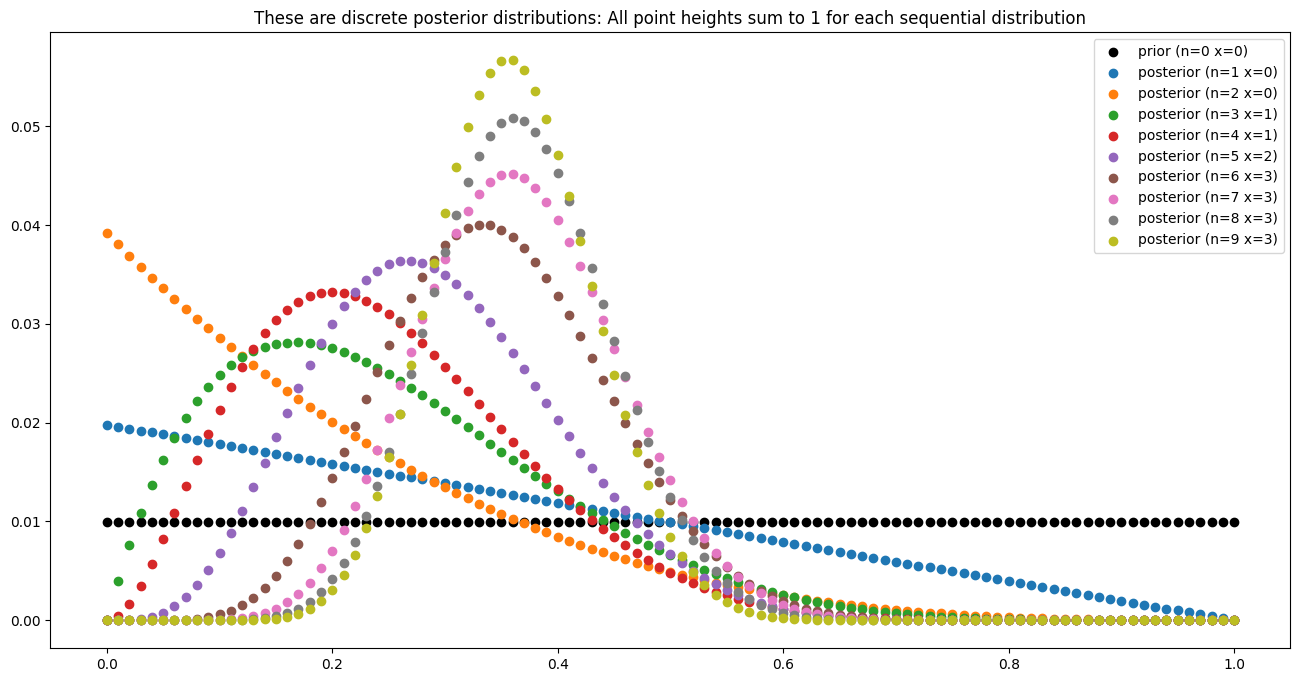

In [7]:
# Q1

import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

parameter_domain = np.linspace(0,1,101)
prior = np.ones(101)/101

observations = 0,0,1,0,1,1,0,0,0
n,x = 0,0
plt.figure(figsize=(16,8))
plt.scatter(parameter_domain, prior, label="prior (n="+str(n)+" x="+str(x)+")", color='k')
plt.title("These are discrete posterior distributions: All point heights sum to 1 for each sequential distribution")

for observation in observations:
    n += 1
    x += observation
    # use these for batch updates based on a binomial distribution
    likelihood = stats.binom.pmf(x, n, parameter_domain)

    # or do updates in a truly sequential manner using Bernoulli
    # likelihood = parameter_domain**observation * (1 - parameter_domain)**(1 - observation)

    posterior = likelihood * prior
    posterior = posterior / posterior.sum()  # normalizing

    plt.scatter(parameter_domain, posterior, label="posterior (n="+str(n)+" x="+str(x)+")")

    # Update the prior for the next iteration
    prior = posterior

plt.legend()

### Q2

The posteriors follow a beta distribution with updated parameters:
$\theta_j \sim \text{Beta}(\alpha_j + x_j, \beta_j + n_j - x_j),$
where $\alpha_j$ represents prior successes, $\beta_j$ represents prior failures, $x_j$ is observed successes, and $n_j$ is the total number of trials.

The posterior combines the prior Beta distribution with the binomial likelihood, which retains the Beta distribution form.

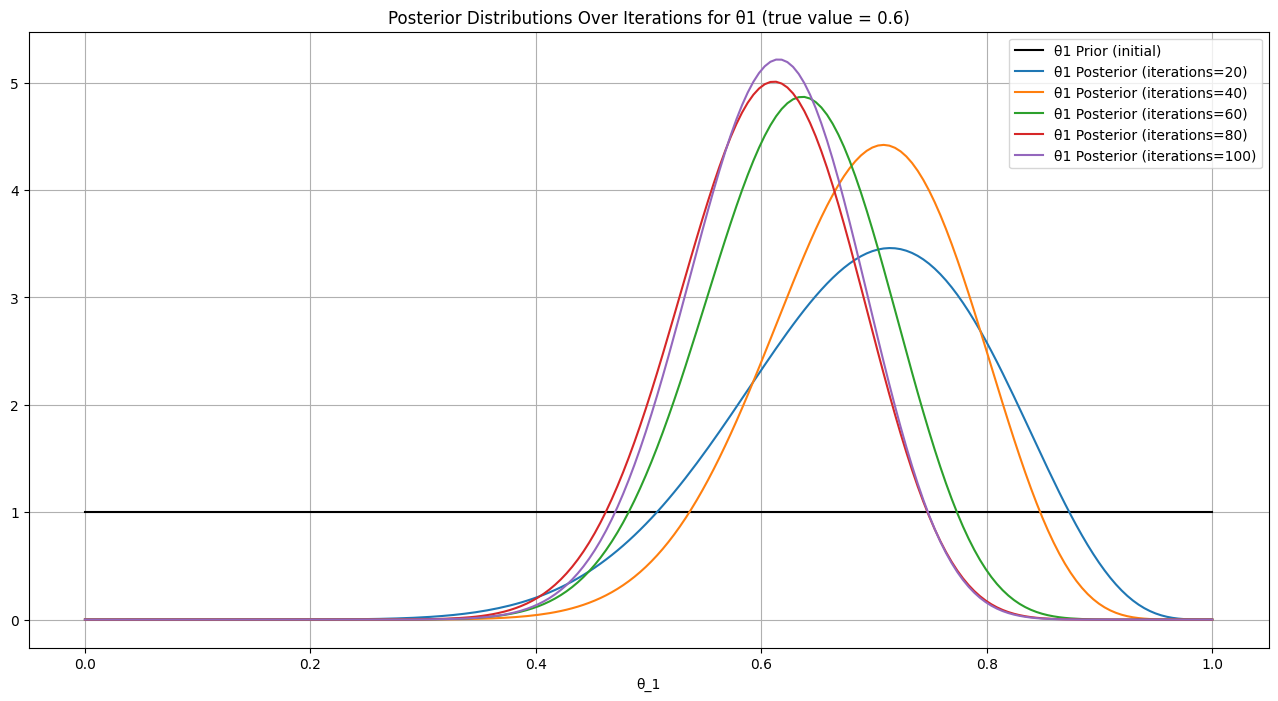

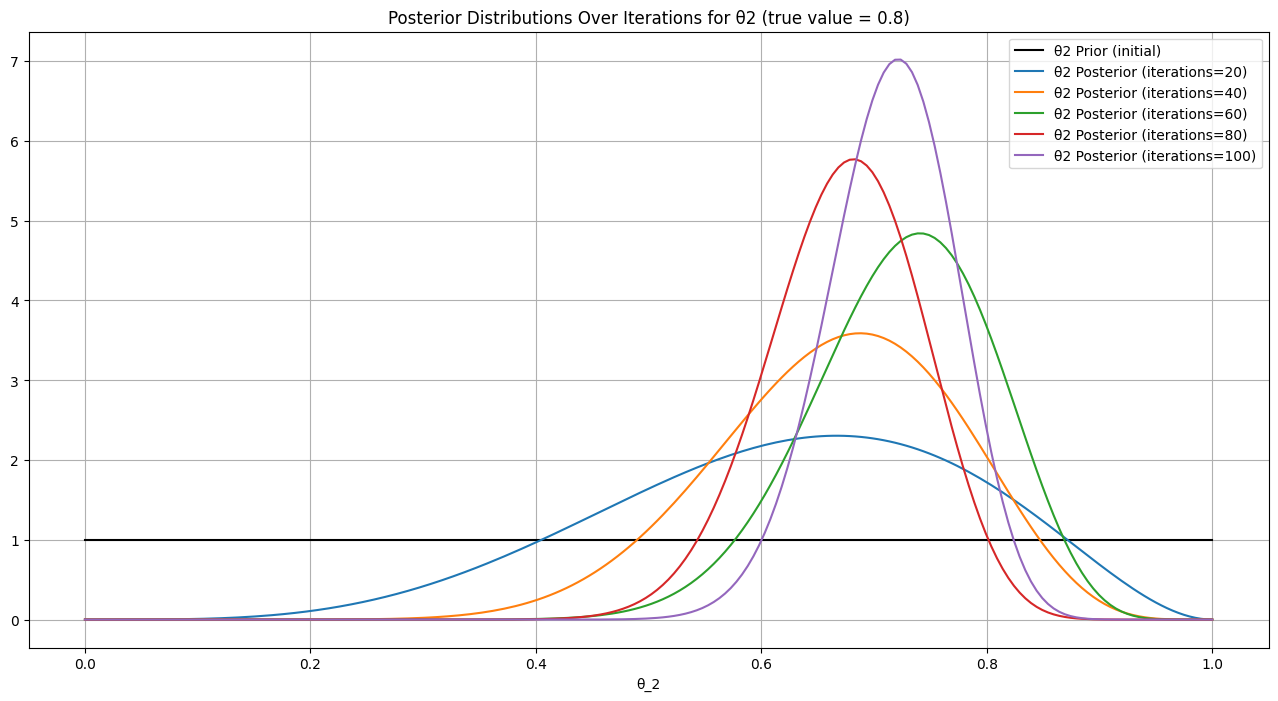

Final counts: n_1=39, x_1=24, n_2=61, x_2=44


In [8]:
# Q2

import numpy as np
from scipy import stats
from scipy.stats import beta
import matplotlib.pyplot as plt
np.random.seed(424)

# Priors for coin 1 and 2
alpha_1, beta_1 = 1, 1
alpha_2, beta_2 = 1, 1

# True success probabilities
theta1_true = 0.6
theta2_true = 0.8

# Step 2: Set to 0 trials and successes initially
n1, x1 = 0, 0
n2, x2 = 0, 0

# plots
parameter_domain = np.linspace(0, 1, 200)

# figures and axes for θ1 and θ2, priors
fig_theta1, ax_theta1 = plt.subplots(figsize=(16, 8))
fig_theta2, ax_theta2 = plt.subplots(figsize=(16, 8))

prior1 = beta.pdf(parameter_domain, alpha_1, beta_1)
ax_theta1.plot(parameter_domain, prior1, label="θ1 Prior (initial)", color='black')

prior2 = beta.pdf(parameter_domain, alpha_2, beta_2)
ax_theta2.plot(parameter_domain, prior2, label="θ2 Prior (initial)", color='black')

m = 100
for t in range(m):
    # Sample from posteriors (updated after every flip)
    theta1_sample = np.random.beta(alpha_1 + x1, beta_1 + n1 - x1)
    theta2_sample = np.random.beta(alpha_2 + x2, beta_2 + n2 - x2)

    # Step 3: Decide which coin to flip
    if theta1_sample < theta2_sample:
        # Step 4:  flip coin 2, update n and x
        n2 += 1
        # get a random probabiliity for theta and compare it to the true pb.
        if np.random.rand() < theta2_true:
            x2 += 1
    else:
        # flip coin 1
        n1 += 1
        if np.random.rand() < theta1_true:
            x1 += 1

    # Automatically learns by keeping track of x1, x2, n1, n2. Samples from the
    # posterior distributions of each theta's success probability to decide
    # which coin to flip. As observed successes/failures refine posteriors,
    # algorithm learns which coin has the higher true success probability.

    # Plot posteriors every 20 iterations
    if (t+1) % 20 == 0 and t > 0:
        posterior1 = beta.pdf(parameter_domain, alpha_1 + x1, beta_1 + n1 - x1)
        posterior2 = beta.pdf(parameter_domain, alpha_2 + x2, beta_2 + n2 - x2)

        # Add to θ1 plot
        plt.figure(1)
        plt.plot(parameter_domain, posterior1, label=f"θ1 Posterior (iterations={t+1})")

        # Add to θ2 plot
        plt.figure(2)
        plt.plot(parameter_domain, posterior2, label=f"θ2 Posterior (iterations={t+1})")

# Finalize θ1 plot
ax_theta1.set_title("Posterior Distributions Over Iterations for θ1 (true value = 0.6)")
ax_theta1.set_xlabel("θ_1")
ax_theta1.legend()
ax_theta1.grid()

# Finalize θ2 plot
ax_theta2.set_title("Posterior Distributions Over Iterations for θ2 (true value = 0.8)")
ax_theta2.set_xlabel("θ_2")
ax_theta2.legend()
ax_theta2.grid()

# Show the plots
plt.show()

print(f"Final counts: n_1={n1}, x_1={x1}, n_2={n2}, x_2={x2}")

### Q3

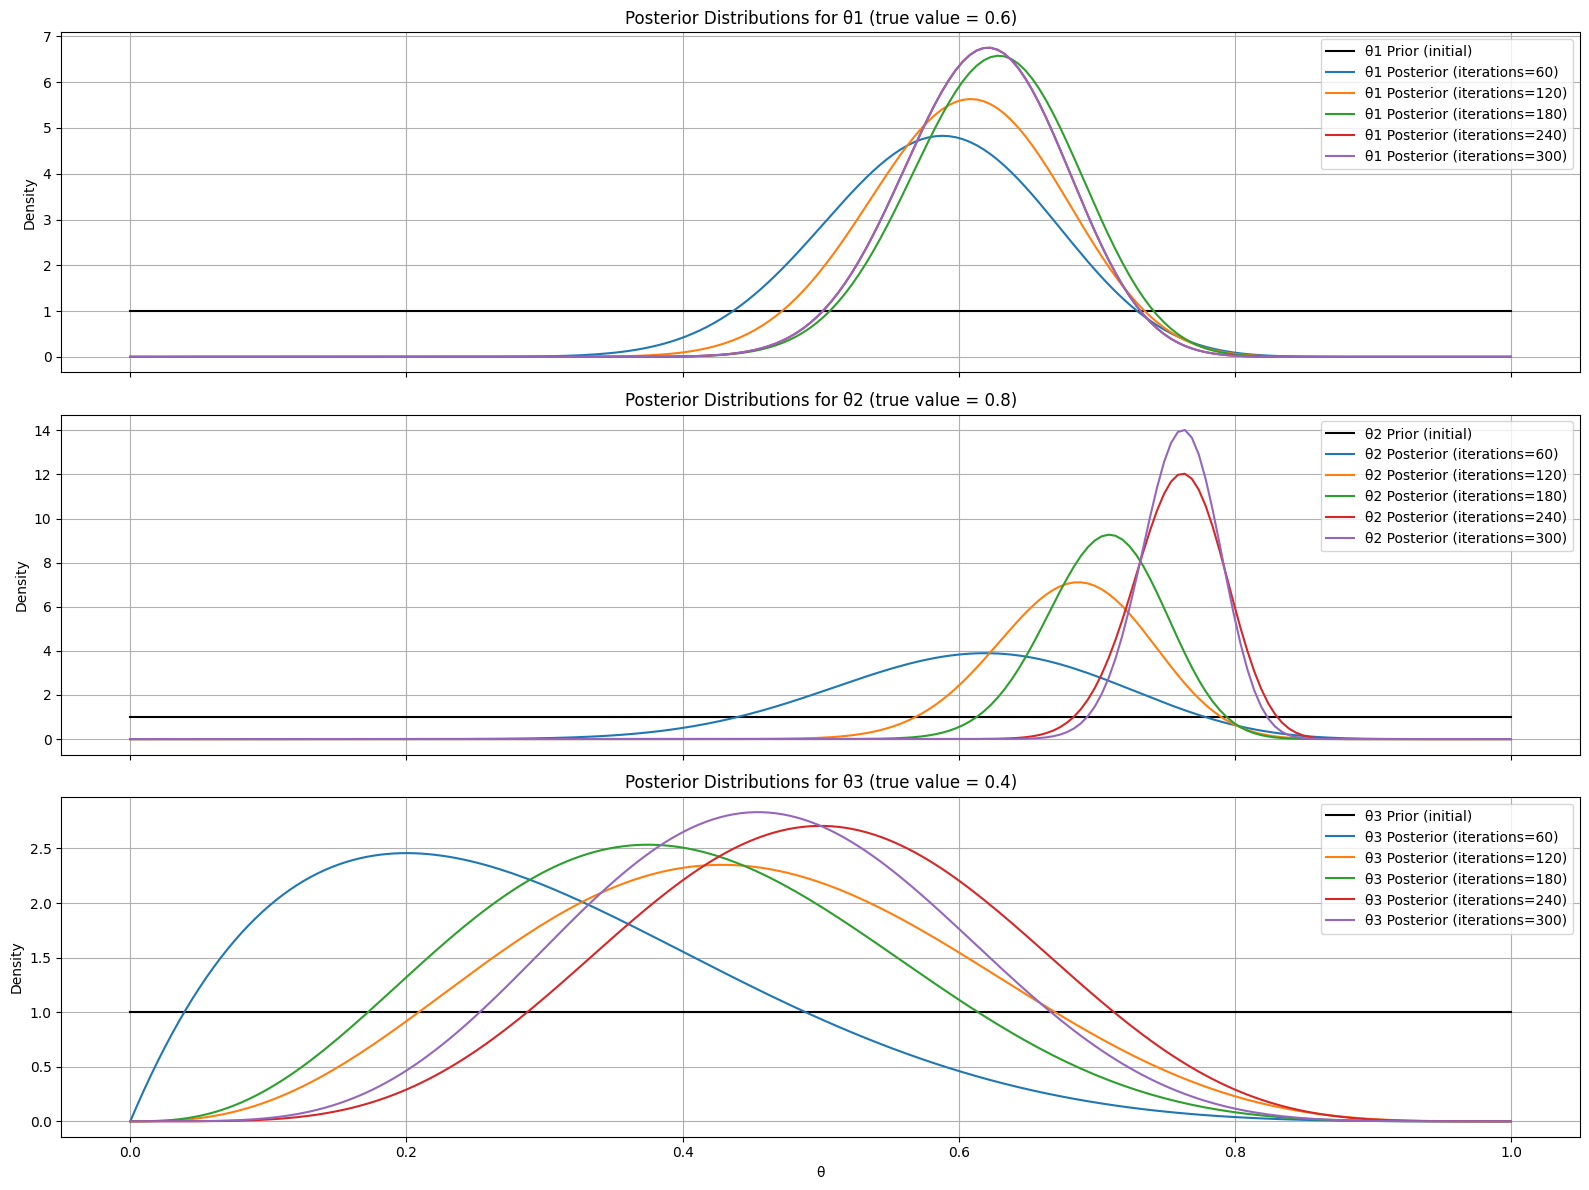

Entity 1: n = 66, x = 41, Estimated θ = 0.621
Entity 2: n = 223, x = 170, Estimated θ = 0.762
Entity 3: n = 11, x = 5, Estimated θ = 0.455


In [9]:
# Analysis 1 (Independent Beta-Binomial Models)
# Analyze each entity independently as we did earlier.

import numpy as np
from scipy.stats import beta
import matplotlib.pyplot as plt
np.random.seed(1)

# Priors for θ1, θ2, θ3
alpha = np.array([1, 1, 1])
beta_params = np.array([1, 1, 1])

# True success probabilities
theta_true = np.array([0.6, 0.8, 0.4])

# Set to 0 trials and successes initially
n = np.array([0, 0, 0])  # trials
x = np.array([0, 0, 0])  # successe

# plots
parameter_domain = np.linspace(0, 1, 200)
fig, axes = plt.subplots(3, 1, figsize=(16, 12), sharex=True)

# Plot priors for all entities
for i, ax in enumerate(axes):
    prior = beta.pdf(parameter_domain, alpha[i], beta_params[i])
    ax.plot(parameter_domain, prior, label=f"θ{i+1} Prior (initial)", color='black')
    ax.set_title(f"Posterior Distributions for θ{i+1} (true value = {theta_true[i]})")
    ax.set_ylabel("Density")
    ax.legend()
    ax.grid()

m = 300
for t in range(m):
    # Sample from posteriors (updated after every flip)
    samples = np.random.beta(alpha + x, beta_params + n - x)

    # Decide which coin to flip
    max_coin = np.argmax(samples)

    n[max_coin] += 1
    if np.random.rand() < theta_true[max_coin]:
        x[max_coin] += 1

    # Plot posteriors every 60 iterations
    if (t+1) % 60 == 0 and t > 0:
        for i, ax in enumerate(axes):
            posterior = beta.pdf(parameter_domain, alpha[i] + x[i], beta_params[i] + n[i] - x[i])
            ax.plot(parameter_domain, posterior, label=f"θ{i+1} Posterior (iterations={t+1})")

# Finalize plots
axes[-1].set_xlabel("θ")
for ax in axes:
    ax.legend()
plt.tight_layout()
plt.show()

# Print final counts
for i in range(len(theta_true)):
    print(f"Entity {i+1}: n = {n[i]}, x = {x[i]}, Estimated θ = {(x[i] / n[i]):.3f}")

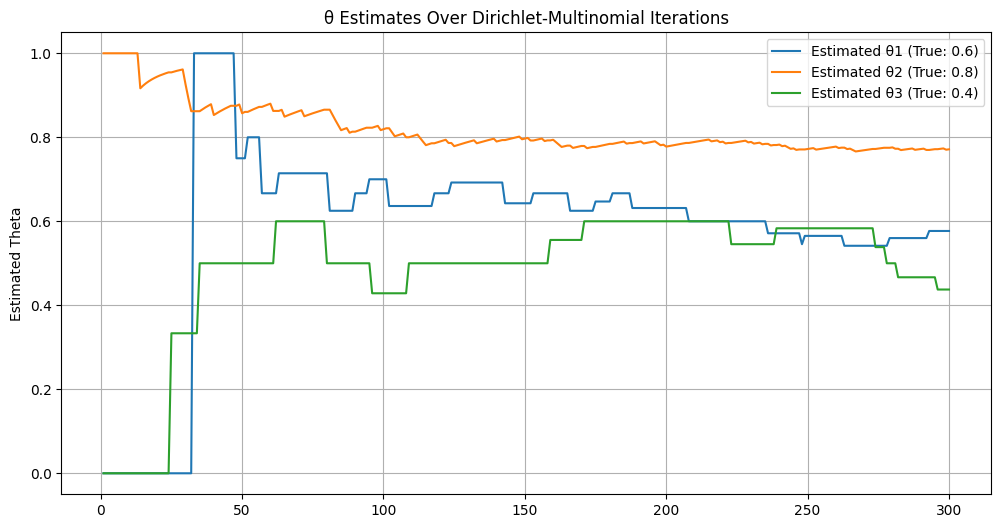

{'Entity': [1, 2, 3],
 'Trials (n)': array([ 26, 258,  16]),
 'Successes (x)': array([ 15, 199,   7]),
 'Estimated θ': array([0.57692308, 0.77131783, 0.4375    ]),
 'Posterior Parameters': array([ 16, 200,   8])}

In [6]:
# Analysis 2: Dirichlet-Multinomial Model
# Analyze all entities together.

import numpy as np
from scipy.stats import dirichlet
import plotly.figure_factory as ff
import matplotlib.pyplot as plt
np.random.seed(1)

# True success probabilities
theta_true = np.array([0.6, 0.8, 0.4])

dirichlet_prior = np.array([1, 1, 1])
dirichlet_n = np.array([0, 0, 0])  # trials
dirichlet_x = np.array([0, 0, 0])  # success

m=300

# Track estimated theta values over time
theta_estimates = []

for t in range(m):
    # Sample from Dirichlet posterior
    theta_sample = np.random.dirichlet(dirichlet_prior + dirichlet_x)

    # Decide which theta coin to flip
    epsilon=0.2 # 20% we flip a random coin. this will distribute the selections
    # so that early selections do not affect the sample too strongly.
    if np.random.rand() < epsilon:
        max_coin = np.random.choice(len(theta_true))  # Randomly select
    else:
        max_coin = np.argmax(theta_sample)  # Exploit best choice
    dirichlet_n[max_coin] += 1
    if np.random.rand() < theta_true[max_coin]:
        dirichlet_x[max_coin] += 1

    # Update theta estimates
    theta_estimates.append(
        np.divide(dirichlet_x, dirichlet_n, out=np.zeros_like(dirichlet_x, dtype=float), where=dirichlet_n != 0)
    )

theta_estimates = np.array(theta_estimates)
# Plot the updates for each theta
plt.figure(figsize=(12, 6))
for i in range(len(theta_true)):
    plt.plot(range(1, m + 1), theta_estimates[:, i], label=f"Estimated θ{i+1} (True: {theta_true[i]})")

plt.title("θ Estimates Over Dirichlet-Multinomial Iterations")
plt.ylabel("Estimated Theta")
plt.legend()
plt.grid()
plt.show()

# Final results
final_results = {
    "Entity": [1, 2, 3],
    "Trials (n)": dirichlet_n,
    "Successes (x)": dirichlet_x,
    "Estimated θ": dirichlet_x / dirichlet_n,
    "Posterior Parameters": dirichlet_prior + dirichlet_x
}
final_results

Q3 Discussion:

- Explanation of $\epsilon$ = 0.2: This is the $\epsilon$-greedy strategy, which introduces a small probability ($\epsilon$) of randomly selecting a category instead of always choosing the one with the highest sampled probability. We do this to encourage exploration (gathering more data about less-sampled categories) and prevent over-committing to categories favoured in early observations.

Analysis 1 (independent beta-binomial) seems to be most appropriate when the entities are independent of each other, such as when they represent coin flips of some probability (as in our example) or entirely separate entities with no interaction and entirely independent probabilities. In this method, the evidence for one entity only influences its own posterior and does not influence the posterior beliefs of another. All entities' posteriors are estimated individually.

Analysis 2 (Dirichlet-Multinomial) is more suitable when the entities are related or dependent, such as when they represent parts of a shared structure (e.g., competitors for a fixed market share). This joint modeling approach naturally accounts for such dependencies, which is not possible when analyzing entities individually. When using this method, we can use strategies such as the
$\epsilon$-greedy strategy discussed above, which helps to ounteract early dominance by encouraging exploration of less-sampled entities. This helps the Dirichlet-Multinomial analysis sample all entities while preferring those that are successful early.

I believe Dirichlet-Multinomial analysis is the most appropriate approach for multi-armed bandit problems in real-world contexts. In the real world, entities are usually not entirely independent - resources or outcomes are often constrained or shared between entities. For example, if a company creates three different social media advertisements (eg. with different styles or colours) and wants to perform an A/B test comparing how much engagement they draw on a platform, people can only view one ad at a time, and whichever one finds initial success (gathers interactions) is likely to continue being successful. The Dirichlet-Multinomial approach accounts for this relationship, ensuring that the sampling process adjusts for the relative success of ads. In contrast, the independent beta-binomial method would treat each ad as if it were being tested on separate groups of users without overlap, which is unlikely considering they are on the same platform and share the same possible user interactions. Dirichlet-Multinomial analysis appears to be more conducive to understanding the effectiveness of each entity in the A/B test.